In [16]:
# Importing dependencies
import numpy as np
import PIL
import matplotlib.pyplot as plt
from zipfile import ZipFile
import tensorflow as tf
from tensorflow.keras import layers # False warning
import os
import csv
import cv2

In [1]:
# Downloading dataset
!gdown "https://drive.google.com/uc?id=1fSu9gWbu4MOf7N9u7ir9D5Z6xbKJJnZp&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1fSu9gWbu4MOf7N9u7ir9D5Z6xbKJJnZp&confirm=t
To: /content/GTSRB_dataset.zip
100% 642M/642M [00:10<00:00, 60.5MB/s]


In [4]:
# Extracting dataset
with ZipFile("GTSRB_dataset.zip", 'r') as zip:
    print('Extracting all the files now...')
    zip.extractall('/content/GTSRB_dataset')
    zip.close()
    print('Extraction done!')

Extracting all the files now...
Extraction done!


<class 'int'>


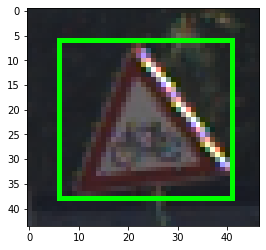

In [34]:
# Showing a sample image
drive_path_corr = '/content/GTSRB_dataset/'
sample_img_path = 'Train/29/00029_00001_00010.png'
img = np.array(PIL.Image.open(drive_path_corr + sample_img_path))

# Showing the bounding boxes
with open('/content/GTSRB_dataset/Train.csv', mode ='r')as file:
  # reading the CSV file
  training_csv = csv.reader(file)
  for row in training_csv:
    if row[7] == sample_img_path:
      x1 = int(row[2])
      y1 = int(row[3])
      x2 = int(row[4])
      y2 = int(row[5])
print(type(x1))
img = cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 1)
plt.imshow(img)

In [ ]:
# Defining parameters for data loading
TRAIN_SET_PATH = '/content/GTSRB_dataset/Train'
TRAIN_BATCH_SIZE = 128
IMG_HEIGHT = 40
IMG_WIDTH = 40

VAL_BATCH_SIZE = 128
VAL_SPLIT_RATIO = 0.2

In [ ]:
# Loading data
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_SET_PATH,
    validation_split = VAL_SPLIT_RATIO,
    subset = "training",
    seed=123,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = (TRAIN_BATCH_SIZE)
)
print(type(train_ds))

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_SET_PATH,
    validation_split = VAL_SPLIT_RATIO,
    subset = "validation",
    seed=123,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = (VAL_BATCH_SIZE)
)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


In [ ]:
# Checking class names
class_names = train_ds.class_names
print(class_names)

# Modifying class names for actual labels
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


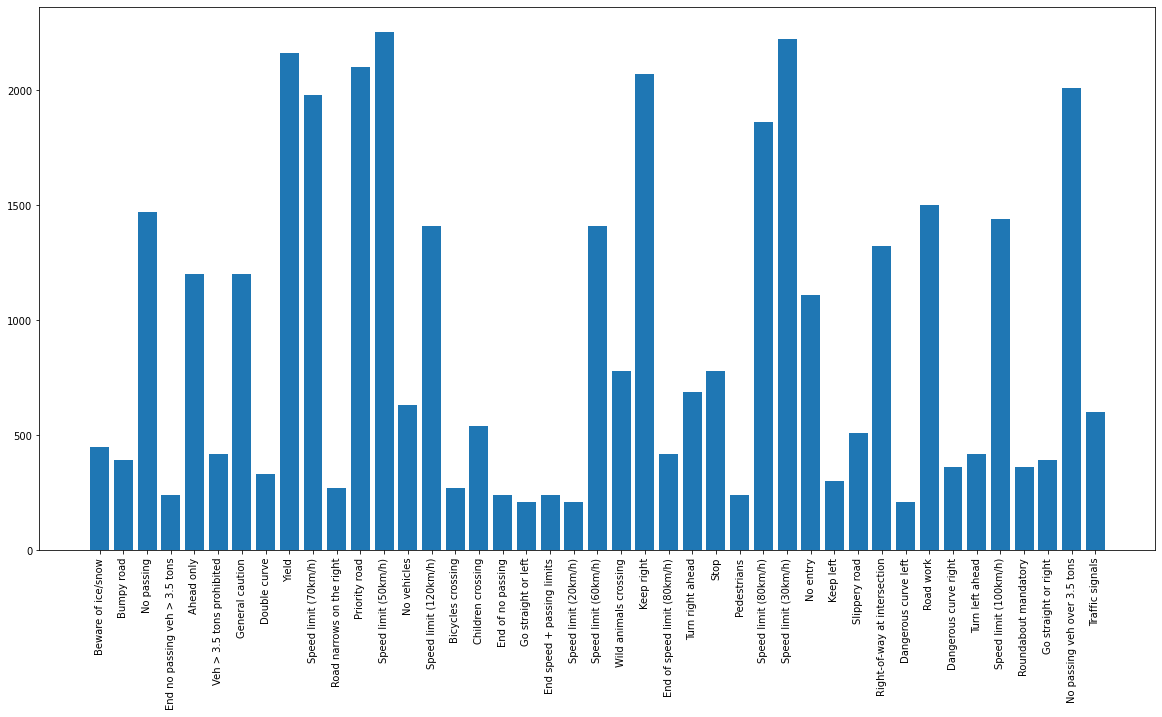

In [ ]:
# Showing the distribution of the different classes
folders = os.listdir(TRAIN_SET_PATH)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(TRAIN_SET_PATH + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Plotting the number of images in each class
plt.figure(figsize=(20,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

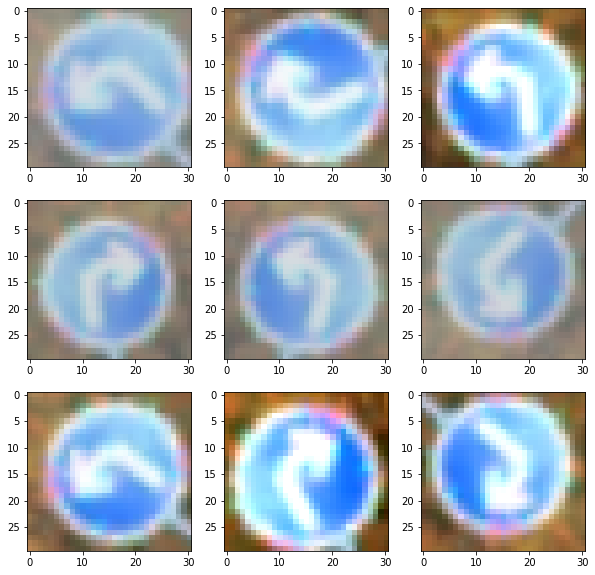

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(height_factor=(-0.2, -0.3)),
    layers.RandomContrast(factor=0.5)
])

# Augmenting the dataset
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(tf.expand_dims(img,0))
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0]/255)

In [ ]:
# Creating the model
num_classes = len(class_names)

model = tf.keras.Sequential([
  layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Showing model summary
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 40, 40, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 40, 40, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 20, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)      

In [ ]:
# Training the model
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
246/246 [==============================] - 84s 336ms/step - loss: 1.2949 - accuracy: 0.6085 - val_loss: 0.6296 - val_accuracy: 0.8221
Epoch 2/5
246/246 [==============================] - 78s 316ms/step - loss: 0.4294 - accuracy: 0.8734 - val_loss: 0.3276 - val_accuracy: 0.9088
Epoch 3/5
246/246 [==============================] - 73s 297ms/step - loss: 0.2139 - accuracy: 0.9381 - val_loss: 0.2087 - val_accuracy: 0.9407
Epoch 4/5
246/246 [==============================] - 79s 320ms/step - loss: 0.1150 - accuracy: 0.9693 - val_loss: 0.1456 - val_accuracy: 0.9612
Epoch 5/5
246/246 [==============================] - 76s 308ms/step - loss: 0.0730 - accuracy: 0.9808 - val_loss: 0.1087 - val_accuracy: 0.9726


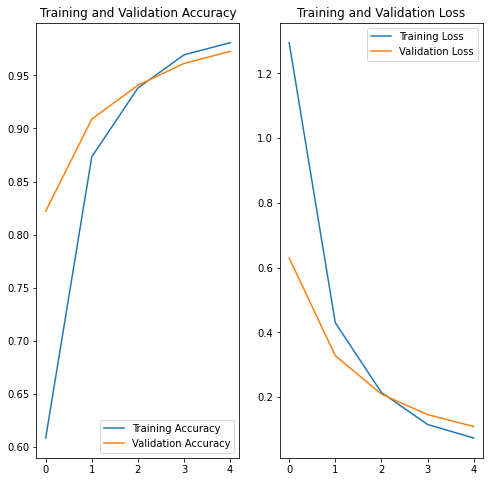

In [ ]:
# Visualizing the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Test image
!gdown https://drive.google.com/uc?id=1piDxGyZMYmknVKCjZXiV3sJe-8pA6JYk

Downloading...
From: https://drive.google.com/uc?id=1piDxGyZMYmknVKCjZXiV3sJe-8pA6JYk
To: /content/test_image2.png
100% 4.87k/4.87k [00:00<00:00, 6.70MB/s]


In [ ]:
test_image_path = '/content/test_image2.png'

img = tf.keras.utils.load_img(
    test_image_path, target_size=(IMG_HEIGHT, IMG_WIDTH)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to \"{}\" with a {:.2f} percent confidence."
    .format(classes[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 24ms/step
This image most likely belongs to "Speed limit (60km/h)" with a 32.66 percent confidence.
